In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import shutil
from tqdm.notebook import tqdm

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from tensorflow.keras.models import load_model


EPOCHS = 300
N_HIDDEN = 128
OBSERVE_LENGTH = 10
PREDICT_LENGTH = 5
FEAT_DIM = 12
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
IMG_DIM = 1536

MODEL_NAME = 'sslstm-image-front_epoch_{}_hidden_{}_observe_{}_predict_{}'.format(EPOCHS, N_HIDDEN, OBSERVE_LENGTH, PREDICT_LENGTH)
model_path = '/home/zg2309/model/{}.h5'.format(MODEL_NAME)
print(model_path)
# load model
model = load_model(model_path)
# summarize model.
model.summary()

/home/zg2309/model/sslstm-image-front_epoch_300_hidden_128_observe_10_predict_5.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 1536)]   0                                            
_______________________________________

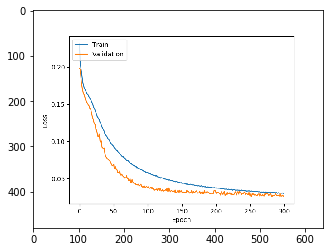

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('/home/zg2309/history/{}.png'.format(MODEL_NAME))
plt.imshow(img)
plt.show()

In [4]:
def visualize_trajectory(prediction, gt, folder):
    
    FPS = 10
    DT = 1.0 / FPS
    times = [t * DT for t in range(0, len(gt))]
    
    gtx = gt[:,0]
    predx = prediction[:,0]
    fig1, ax1 = plt.subplots()
    ax1.plot(times, gtx, label='gt')
    
    ax1.plot(times, predx, label="predict")
    
    ax1.set_ylabel('acceleration x')
    ax1.set_xlabel('time')
    fig1.savefig(folder + 'acceleration_x.png')
    
    gty = gt[:,1]
    predy = prediction[:,1]
    fig2, ax2 = plt.subplots()
    ax2.plot(times, gty, label='gt')
    
    ax2.plot(times, predy, label="predict")
    
    ax2.set_ylabel('acceleration y')
    ax2.set_xlabel('time')
    fig2.savefig(folder + 'acceleration_y.png')
    
    plt.close(fig1)
    plt.close(fig2)
#     gtz = gt[:,2]
#     predz = prediction[:,2]
#     fig3, ax3 = plt.subplots()
#     ax3.plot(times, gtz, label='gt')
    
#     ax3.plot(times, predz, label="predict")
    
#     ax3.set_ylabel('acceleration z')
#     ax3.set_xlabel('time')
#     fig3.show()

def MAE(predict, label):
    result = np.abs(predict - label)
    result = result.reshape((-1,2))
    return np.mean(result, axis=0)
    
def MSE(predict, label):
    result = (predict - label)**2
    result = result.reshape((-1, 2))
    return np.mean(result, axis=0)

def total_MAE(predict, label):
    result = (predict - label)**2
    result = np.sum(result, axis=1)
    result = np.sqrt(result)
    return np.mean(result)
    
def total_MSE(predict, label):
    result = (predict - label)**2
    result = np.sum(result, axis=1)
    return np.mean(result)

def predict(raw, image_path):
    length, _ = raw.shape
    prediction = np.zeros((length, 3))
    prediction[:OBSERVE_LENGTH, :] = raw[:OBSERVE_LENGTH, -3:].copy()
    acceleration = np.zeros((length, 3))
    acceleration[:OBSERVE_LENGTH, :] = raw[:OBSERVE_LENGTH, -3:].copy()
    
    predict_start = OBSERVE_LENGTH
    
    while predict_start < length:
        if predict_start + PREDICT_LENGTH > length:
            predict_start = length - PREDICT_LENGTH
        
        
        X_feat = np.zeros((1,OBSERVE_LENGTH,FEAT_DIM))
        X_image = np.zeros((1,OBSERVE_LENGTH,IMG_DIM))
        #load feats
        X_feat[0,:,:] = raw[predict_start - OBSERVE_LENGTH:predict_start, :-3]
        for i in range(OBSERVE_LENGTH):
            img_path_0 = '/home/dataset/images/0/validation/' + tar_name + '/' + seg_name + '/'
            X_image[0, i, :] = np.load(img_path_0 + '{}.npy'.format(predict_start - OBSERVE_LENGTH + i))
        
        predict_y = model.predict([X_image, X_feat])
        prediction[predict_start:predict_start+PREDICT_LENGTH, :] = predict_y.squeeze().copy()
        acceleration[predict_start:predict_start+PREDICT_LENGTH, :] = predict_y.squeeze().copy()
        
        predict_start = predict_start + PREDICT_LENGTH
        
    return prediction[:, :2]

In [5]:
BOX_PTS = 9
TEST_FILES = '/home/dataset/data/validation/validation*/*_smooth_{}.csv'.format(BOX_PTS)

test_csvs = glob.glob(TEST_FILES)
test_num = len(test_csvs)
# print(test_csvs)
print('test csvs num:', len(test_csvs))
dim_input = 15

total_mae = []
total_mse = []

total_prediction = []
total_gt = []

predict_path = '/home/zg2309/prediction/{}/'.format(MODEL_NAME)
img_prefix = '/home/dataset/images/0/validation/'
if os.path.exists(predict_path):
    shutil.rmtree(predict_path)
os.mkdir(predict_path)

for csv in tqdm(test_csvs):
    raw = pd.read_csv(csv).values
    gt = raw[:,-3:]
    gt = gt[:, :2]
    
    tar_name = csv.split('/')[5]
    tar_path = predict_path + tar_name + '/'

    if not os.path.exists(tar_path):
        os.mkdir(tar_path)
        
    seg_name = csv.split('/')[6][:-13]
    
    if tar_name in seg_name:
        tar_len = len(tar_name)
        seg_name = seg_name[tar_len+1:]
    
    img_path = img_prefix + tar_name + '/' + seg_name + '/'
    prediction = predict(raw, img_path)
    
    folder = tar_path + seg_name + '/'
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)
    
    np.save(folder + 'prediction.npy', prediction)
    
    visualize_trajectory(prediction, gt, folder)
    
    mae_x, mae_y = MAE(prediction, gt)
    mse_x, mse_y = MSE(prediction, gt)

    total_mae.append(np.array([mae_x,mae_y]))
    total_mse.append(np.array([mse_x,mse_y]))
    
    if total_gt == []:
        total_gt = gt
    else:
        total_gt = np.vstack((total_gt, gt))
       
    if total_prediction == []:
        total_prediction = prediction
    else:
        total_prediction = np.vstack((total_prediction, prediction))        

test csvs num: 150


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [6]:
tMAE = total_MAE(total_prediction, total_gt)
tMSE = total_MSE(total_prediction, total_gt)
print('tMAE: ', tMAE)
print('tMSE: ', tMSE)
total_mae = np.array(total_mae)
total_mse = np.array(total_mse)
print('MAE X Y: ', np.mean(total_mae, axis=0))
print('MSE X Y: ', np.mean(total_mse, axis=0))

tMAE:  0.21609417706500952
tMSE:  0.09453866315192118
MAE X Y:  [0.13791158 0.12789032]
MSE X Y:  [0.04790631 0.04661391]


In [7]:
prediction.shape

(198, 2)